In [4]:
import requests

def download(url, filename):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, "wb") as f:
                f.write(response.content)
            print(f"Downloaded {filename} from {url}")
        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [7]:
path= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv'
download(path,"yellow_tripdata_2019-06.csv")

Downloaded yellow_tripdata_2019-06.csv from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv


In [5]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [33]:
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("There are "+ str(len(raw_data)) + " obser")
print("There are "+ str(len(raw_data.columns)) + " variables")
raw_data.head()


There are 3936004 obser
There are 18 variables


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [9]:
raw_data = raw_data.head(100000)

In [10]:
raw_data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

In [34]:
raw_data = raw_data[raw_data['tip_amount'] > 0]

raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

raw_data = raw_data[(raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] <= 200)]

clean_data = raw_data.drop(['total_amount'], axis=1)

del raw_data
gc.collect()

1758

There are 65351 observations in the dataset.
There are 17 variables in the dataset.
Maximum amount:  60.09
Minimum amount:  0.01
90%:  5.15


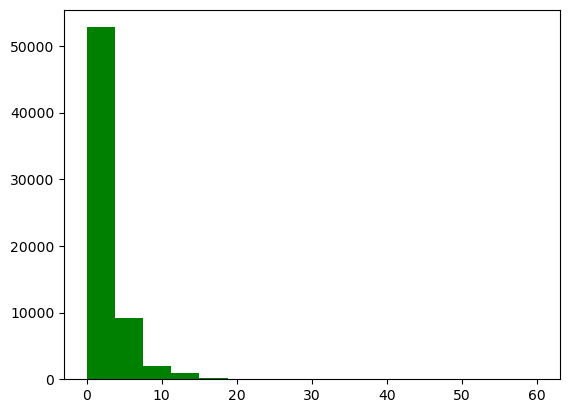

In [26]:
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 16,histtype='bar', facecolor='g')

print("Maximum amount: ", np.max(clean_data.tip_amount.values))
print("Minimum amount: ", np.min(clean_data.tip_amount.values))
print("90%: ", np.percentile(clean_data.tip_amount.values, 90))

In [27]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


In [35]:
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

clean_data.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,...,0.5,2.65,0.0,0.3,2.5,0,0,5,5,12.0
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,...,0.5,1.00,0.0,0.3,2.5,0,0,5,5,10.0
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,...,0.5,1.00,0.0,0.3,2.5,0,1,5,5,8.0
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,...,0.5,7.05,0.0,0.3,2.5,0,1,5,5,34.0
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,...,0.5,2.96,0.0,0.3,2.5,0,0,5,5,14.0


In [36]:
clean_data = clean_data.drop(['tpep_dropoff_datetime','tpep_pickup_datetime'],axis = 1)

get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]

proc_data = pd.get_dummies(clean_data, columns=get_dummy_col)

del clean_data
gc.collect()

30

In [38]:
y = proc_data[['tip_amount']].values.astype('float32')

proc_data = proc_data.drop(['tip_amount'],axis=1)

X = proc_data.values

X = normalize(proc_data, norm='l1', copy=False)

print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2712770, 596) y.shape= (2712770, 1)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1898939, 596) Y_train.shape= (1898939, 1)
X_test.shape= (813831, 596) Y_test.shape= (813831, 1)


In [40]:
from sklearn.tree import DecisionTreeRegressor

sklearn_dt = DecisionTreeRegressor(max_depth=8,random_state=35)

t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  131.79750


In [41]:
from snapml import DecisionTreeRegressor

snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[snapml] Training time (s):  {0:.5f}".format(snapml_time))

[snapml] Training time (s):  23.96145


In [42]:
training_speedup = sklearn_time / snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

print("sklearn: ",sklearn_dt.score(X_test,y_test))
print("snapml: ",snapml_dt.score(X_test,y_test))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 5.50x 
sklearn:  0.7711006090274328
snapml:  0.7711229466851796


In [43]:
# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Scikit-Learn] MSE score : 1.662
[Snap ML] MSE score : 1.662
